## Step 1: Import necessary libraries


In [104]:
import numpy as np
import pandas as pd
import re
import nltk
#nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report

## Step 2: Load the Dataset


In [22]:
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('../twitter_data.csv', names=column_names, encoding = 'ISO-8859-1')
twitter_data.shape
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [23]:
twitter_data.isnull().sum()
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

## Step 3: Preprocess the Data

##### 4 -> Positive Tweet and 0 -> Negative Tweet

In [2]:
def lemmatization(content):
    lemmatizer = WordNetLemmatizer()
    content = re.sub('[^a-zA-Z]', ' ', content)  # Remove non-alphabetic characters
    content = content.lower()  # Convert to lowercase
    tokens = content.split()  # Tokenize
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize
    return ' '.join(lemmatized_tokens)  # Return as a single string

In [ ]:
twitter_data['lemmatized_content'] = twitter_data['text'].apply(lemmatization)

In [105]:
twitter_data = pd.read_csv('../twitter_data_cleaned.csv', encoding = 'ISO-8859-1')
twitter_data.shape
twitter_data.head()

,target,id,date,flag,user,text,lemmatized_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived many time ball managed save res...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad see


In [106]:
twitter_data['lemmatized_content'].head()

0    switchfoot http twitpic com zl awww bummer sho...
1    upset update facebook texting might cry result...
2    kenichan dived many time ball managed save res...
3                      whole body feel itchy like fire
4                     nationwideclass behaving mad see
Name: lemmatized_content, dtype: object

In [107]:
twitter_data['target'].head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

## Step 4: Define the Models

We'll use:
- `TfidfVectorizer` for text feature extraction.
- `MultinomialNB` for Naive Bayes classification.
- `LogisticRegression` for LR.
- `VotingClassifier` to combine both using soft voting.


In [108]:
x = twitter_data['lemmatized_content']
y = twitter_data['target'].astype(str)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)

(1280000,) (320000,)


In [109]:
x_train = x_train.fillna("")
x_test = x_test.fillna("")

In [110]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Individual models
nb_model = MultinomialNB()
lr_model = LogisticRegression(max_iter=200, random_state=42)

# VotingClassifier with soft voting (probability average)
ensemble_model = VotingClassifier(
    estimators=[
        ('nb', nb_model),
        ('lr', lr_model)
    ],
    voting='soft'
)


##  Step 5: Create a Pipeline

Building a pipeline to:
1. Convert text to TF-IDF vectors.
2. Apply the VotingClassifier.


In [111]:
# Create the pipeline
model_pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('ensemble', ensemble_model)
])


##  Step 6: Train the Model


In [112]:
model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=5000)),
                ('ensemble',
                 VotingClassifier(estimators=[('nb', MultinomialNB()),
                                              ('lr',
                                               LogisticRegression(max_iter=200,
                                                                  random_state=42))],
                                  voting='soft'))])

##  Step 7: Evaluate the Model

In [113]:
# Predict on test set
y_pred = model_pipeline.predict(x_test)

# Print evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.766459375

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76    159494
           4       0.76      0.78      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



### Save the trained pipeline model

In [114]:
import joblib

joblib.dump(model_pipeline, "model_pipeline.joblib")
print("Model saved as 'model_pipeline.joblib'")


Model saved as 'model_pipeline.joblib'


### Load the trained model pipeline (includes TF-IDF + VotingClassifier)

In [115]:
import joblib

# Load the saved model pipeline
model_pipeline = joblib.load("model_pipeline.joblib")

# Updated label mapping
label_map = {
    0: "Negative Tweet",
    4: "Positive Tweet"
}

def predict_sentiment(texts):
    """
    Predict sentiment (Positive/Negative Tweet) for input text(s).

    Parameters:
    texts (str or list of str): Input sentence(s)
    """
    if isinstance(texts, str):
        texts = [texts]  # Convert single string to list

    predictions = model_pipeline.predict(texts)

    for text, label in zip(texts, predictions):
        sentiment = label_map.get(int(label), f"Unknown ({label})")
        print(f"Text: {text}\nSentiment: {sentiment}\n")


In [116]:
predict_sentiment("The movie was absolutely fantastic!")

predict_sentiment([
    "This is the worst product I’ve ever used.",
    "I really enjoyed the experience, would recommend!"
])


Text: The movie was absolutely fantastic!
Sentiment: Positive Tweet

Text: This is the worst product I’ve ever used.
Sentiment: Negative Tweet

Text: I really enjoyed the experience, would recommend!
Sentiment: Positive Tweet



## Step 8: Visualization of Sentiment Trends

C:\Users\Revanasidda\AppData\Local\Temp\ipykernel_12584\2249097268.py:8: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'])  # Make sure the column name matches your dataset


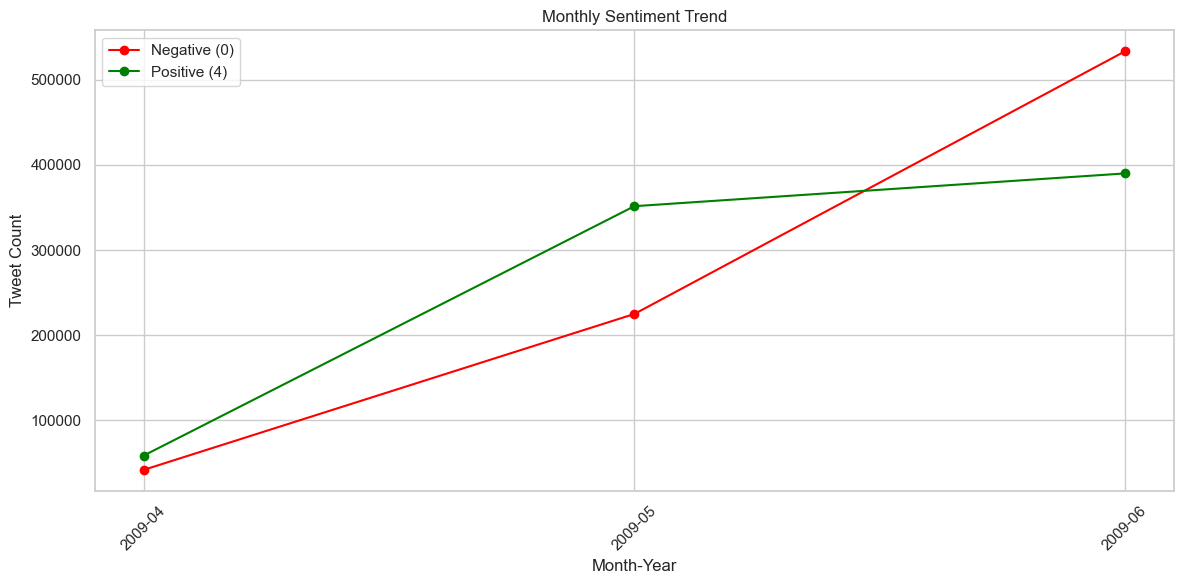

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (update filename and column names as needed)
df = pd.read_csv('../twitter_data_cleaned.csv', encoding = 'ISO-8859-1')

# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])  # Make sure the column name matches your dataset

# Create a new column for month and year
df['month_year'] = df['date'].dt.to_period('M').astype(str)

# Filter sentiment counts
monthly_counts = df.groupby(['month_year', 'target']).size().unstack(fill_value=0).sort_index()

# Extract months and counts
months = monthly_counts.index.tolist()
neg_counts = monthly_counts.get(0, pd.Series([0]*len(months))).tolist()  # Sentiment = 0 (Negative)
pos_counts = monthly_counts.get(4, pd.Series([0]*len(months))).tolist()  # Sentiment = 4 (Positive)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(months, neg_counts, color='red', marker='o', label='Negative (0)')
plt.plot(months, pos_counts, color='green', marker='o', label='Positive (4)')
plt.title('Monthly Sentiment Trend')
plt.xlabel('Month-Year')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!git add .
!git commit -m "Add sentiment trend visualization (Monthly Positive vs Negative tweets)"
!git push origin main